In [23]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import FashionMNIST
from matplotlib import pyplot as plt
from torchvision.utils import save_image
import os
%matplotlib inline

In [24]:
if not os.path.exists('./doc_img/image_{}.png'):
    os.mkdir('./doc_img/image_{}.png')

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [25]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [26]:
# Define the laod data step
weight_decay = 1e-5

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [27]:
input_size  = 28*28   # the size of images are 28x28 pixels
output_size = 10      # we have 10 classes

train_loader = torch.utils.data.DataLoader(
    FashionMNIST('FashionMNIST', train=True, download=True,
                   transform=img_transform #((0.1307,), (0.3081,))
                ),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    FashionMNIST('FashionMNIST', train=False, transform=img_transform),
    batch_size=128, shuffle=True)

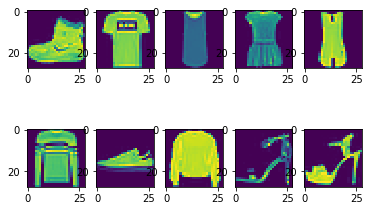

In [28]:
# show some images
plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())

In [29]:
# Define data loading step
dataset = FashionMNIST('FashionMNIST', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
# Model architecture and reconstruction loss
# n= 28x28=784

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),  # b, 16, 10, 10
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2,padding=0),  # b, 16, 5, 5
            nn.Conv2d(in_channels=16, out_channels=8,kernel_size= 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=2, stride=1, padding=0)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=0),  # b, 16, 5, 5
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=5, stride=3, padding=1),  # b, 8, 15, 15
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder().to(device)
criterion = nn.MSELoss()

In [32]:
# Configure the optimiser

learning_rate = 1e-3
L2_regularization = 1e-5

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay= L2_regularization
)

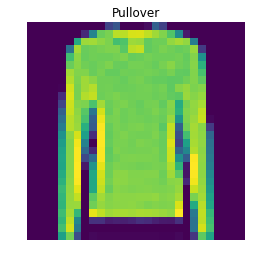

In [33]:
########## Choice of one image ##################

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
import numpy as np
np.random.seed(44)
imag_indx = np.random.randint(len(dataloader));


img_to_trace = dataloader.dataset.train_data[imag_indx].type('torch.FloatTensor')
mean = img_to_trace.mean()
std = img_to_trace.std()
img_to_trace = (img_to_trace - mean)/ std
label_text = labels_map[int(dataloader.dataset.train_labels[imag_indx])]

plt.title(label_text)
plt.axis('off')
plt.imshow(img_to_trace);
img_to_trace = img_to_trace.view(1,1,28,28)

epoch [1/20], loss:0.1178


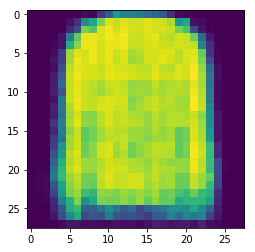

epoch [2/20], loss:0.1117


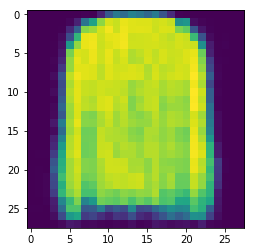

epoch [3/20], loss:0.1014


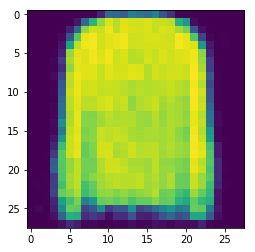

epoch [4/20], loss:0.1033


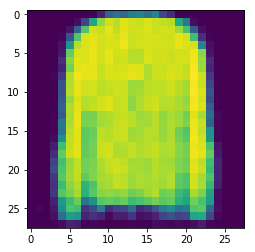

epoch [5/20], loss:0.0912


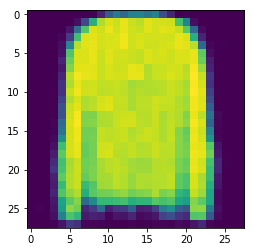

epoch [6/20], loss:0.0979


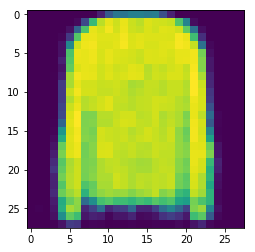

epoch [7/20], loss:0.0906


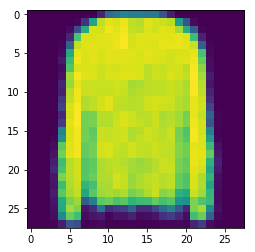

epoch [8/20], loss:0.0815


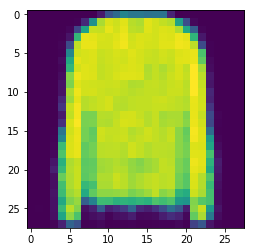

epoch [9/20], loss:0.0921


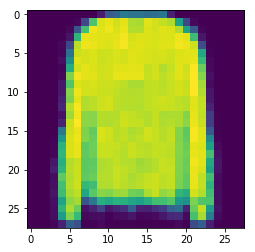

epoch [10/20], loss:0.0880


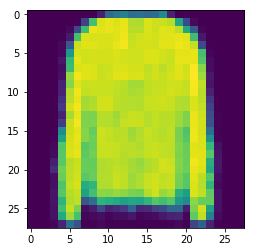

epoch [11/20], loss:0.0849


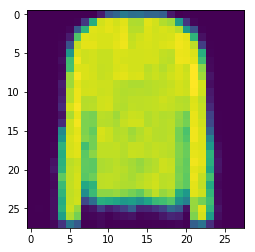

epoch [12/20], loss:0.0919


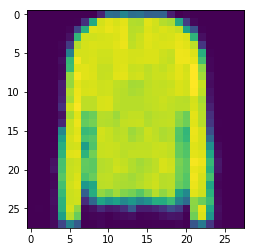

epoch [13/20], loss:0.0847


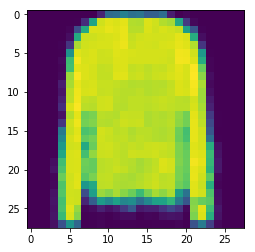

epoch [14/20], loss:0.0826


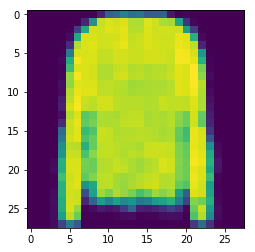

epoch [15/20], loss:0.0774


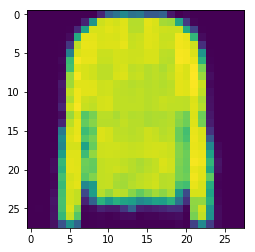

epoch [16/20], loss:0.0742


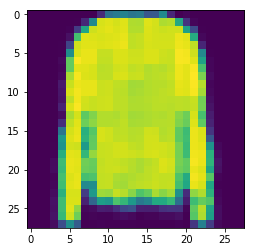

epoch [17/20], loss:0.0748


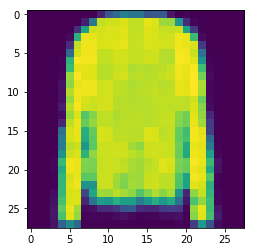

epoch [18/20], loss:0.0869


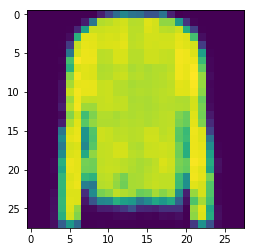

epoch [19/20], loss:0.0897


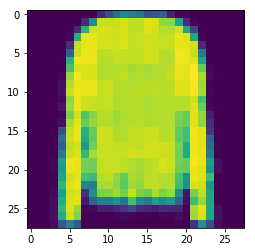

epoch [20/20], loss:0.0769


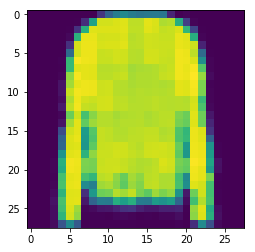

In [36]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in train_loader: #dataloader:
        img, _ = data
        img.requires_grad_()
        img = img.view(-1,1,28,28)
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         # ===================log========================
    print( 'epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()) )
    
    #############  save image ##################
    output_trace = model(img_to_trace)
    out_pic = to_img(output_trace.cpu().data).view(28,28)
    plt.imshow(out_pic)
    #plt.imsave('./fashionMnist_autoencoder_train/'+label_text+'_epoch_'+str(epoch+1), out_pic)
    #save_image(out_pic, './fashionMNist_autoencoder_train/{}.png'.format(epoch+1), normalize=True)
    save_image(out_pic,'./doc_img/image_{}.png'.format(epoch))
    plt.show()

In [38]:
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [39]:
model = autoencoder()
print('nomber of parameters:{}'.format(get_n_params(model)))
parameters = list(model.parameters()) 
for i in range(len(parameters)):
    print(parameters[i].size())

nomber of parameters:5729
torch.Size([16, 1, 3, 3])
torch.Size([16])
torch.Size([8, 16, 3, 3])
torch.Size([8])
torch.Size([8, 16, 3, 3])
torch.Size([16])
torch.Size([16, 8, 5, 5])
torch.Size([8])
torch.Size([8, 1, 2, 2])
torch.Size([1])
